# This notebook is designed to test the procedure for determining the width parameter (s) for the feature weighting.

In [5]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import KFold

plt_num = 0


## Code bits
Below are the main bits of code for the regression - building our design matrix and solving it with a custom feature weighting 

__@Hogg please check the implemention of the feature weighting towards the bottom of this next cell__

In [6]:
def design_matrix(x, period, n_harmonics):

    # We're going to do this as a fourier series, so our design matrix
    # necessarily needs to be the (1 cos() sin()) pairs for each
    # harmonic of the orbital period that we're considering

    # First, we're going to get all the possible cyclic frequencies
    # that we're concerned with, i.e. the N harmonics of the orbital
    # frequency
    omegas = 2. * np.pi * np.arange(1, n_harmonics + 1) / period

    # Next, we instantiate the design matrix to have 2 * n_harmonics + 1 columns
    # since we want an offset term and sin+cos term for each harmonic
    X = np.ones((len(x), 2 * n_harmonics + 1))

    # We do the same to keep track of the actual frequencies in case we
    # want to do the approximate GP regression
    omega_list = np.zeros(2 * n_harmonics + 1)


    # Consider the 0-frequency base term
    #X[:,0] = 1.
    omega_list[0] = 0.

    # Populate the cosine terms
    X[:,1::2] = np.cos(omegas[None, :] * x[:, None]) # I'm dyin heah ## original hogg quote, will not be removing.
    omega_list[1::2] = omegas

    # Populate the cosine terms
    X[:,2::2] = np.sin(omegas[None, :] * x[:, None])
    omega_list[2::2] = omegas

    return X, omega_list


def solve_approxGP(X, diag_omegas, y, width=None, weights=None):

    if width is None:
        width = 0.1 / (2.*np.pi)
    else:
        width /= (2. * np.pi)

    
    ## Assumes the approximation of a periodic version of the Matern 3/2 kernal    
    # Implement eq. 23 from https://arxiv.org/pdf/2101.07256
    # In this case, we're going to use the same X for our predictions
    # however, we could propose a new X* where we want to predict
    # the regression at times t*
    if weights is not None:
        Cinv = np.linalg.inv(np.diag(weights**2))
        A = X.T@Cinv@X
        B = X.T@Cinv@y
    else:
        A = X.T@X
        B = X.T@y


    ## @Hogg, please check HERE  -- I'm not sure that this is the correct way to add the feature weighting
    idd = np.diag_indices_from(A)
    A[idd] += ( (width**2) * (diag_omegas**2) + 1 )**2
    betas = np.linalg.solve( A, B)
    return betas



In [8]:
df = pd.read_csv('../data/RRLyra_ML_01.csv')
dfu = df.loc[df['Filter']=='u']
dfq = df.loc[df['Filter']=='q']
dfi = df.loc[df['Filter']=='i']

dfu = dfu[['MJD', 'Flux [μJy]','Fluxerr [μJy]']]
dfq = dfq[['MJD', 'Flux [μJy]','Fluxerr [μJy]']]
dfi = dfi[['MJD', 'Flux [μJy]','Fluxerr [μJy]']]

In [10]:
flux = dfq['Flux [μJy]'].values
flux_error = dfq['Fluxerr [μJy]'].values
time = dfq['MJD'].values

# Center the flux data
flux_mean = np.mean(flux)
flux_centered = flux - flux_mean

Text(0.5, 1.0, 'Flux vs Time')

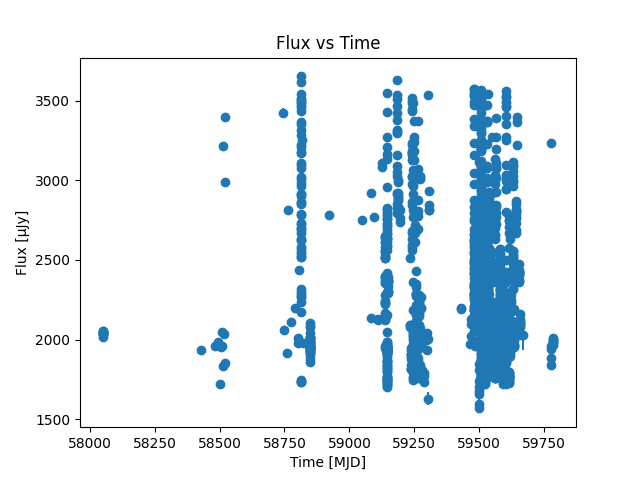

In [11]:
fig, ax = plt.subplots(1, 1, num=plt_num)
plt_num += 1

ax.errorbar(time, flux, yerr=flux_error, fmt='o')
ax.set_xlabel('Time [MJD]')
ax.set_ylabel('Flux [μJy]')
ax.set_title('Flux vs Time')

In [13]:
period_opt = 0.58214

Text(0.5, 1.0, 'Folded light curve')

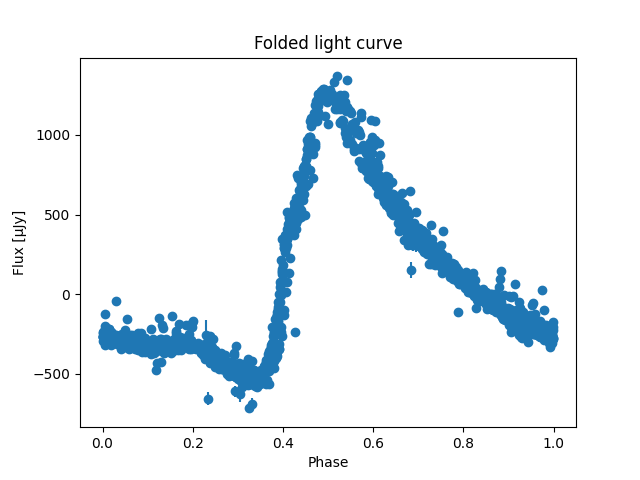

In [15]:
ph_ = (time - time[0])/period_opt % 1
fig, ax = plt.subplots(1,1,num=plt_num)
plt_num += 1

ax.errorbar(ph_, flux_centered, yerr=flux_error, fmt='o')
ax.set_xlabel('Phase')
ax.set_ylabel('Flux [μJy]')
ax.set_title('Folded light curve')


#### Clear outliers -- make a big impact on the fit later

In [21]:
def sort_on_x(x,y,yerr):
        zipp = list(zip(x,y,yerr))
        zipp.sort(key=lambda x:x[0])
        x,y, yerr = list(zip(*zipp))
        return x, y, yerr


def cross_validate_hyperparams(x, y, yerr, period, n_harmonics, n_folds=5, n_trials=50):

    # Create an Optuna study and optimize
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, x, y, yerr, period, n_harmonics, n_folds=n_folds), n_trials=n_trials)

    # Display the best alpha and corresponding score
    print(f"Best width: {study.best_params['width']}")
    print(f"Best MSE: {study.best_value}")

    return study.best_params['width']


def objective(trial, x, y, yerr, period, n_harmonics, n_folds=5):

    width = trial.suggest_loguniform("width", 1e-3, 100.)  # Log-uniform search space
    
    # Perform K-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    mse_scores = []
    

    for train_index, test_index in kf.split(x):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if yerr is None:
            w_train = None
        else:
            w_train, _ = 1./yerr[train_index]**2, 1./yerr[test_index]**2

        # Get the design matrices for the training and test sets
        X_train, omegas_train = design_matrix(x_train, period, n_harmonics)
        X_test, _ = design_matrix(x_test, period, n_harmonics)


        # Call your custom Ridge regression function
        betas_ = solve_approxGP(
            X_train, 
            omegas_train,
            y=y_train, 
            width=width,
            weights=w_train
        )
        
        # Make predictions on the test set
        y_pred = X_test @ betas_
        
        # Compute mean squared error
        mse = np.mean((y_test - y_pred) ** 2)
        mse_scores.append(mse)
    
    # Return the average MSE across folds
    return np.mean(mse_scores)


In [24]:
K=50

width_opt = cross_validate_hyperparams(time, flux_centered, None, period_opt, K)
width_opt_with_errors = cross_validate_hyperparams(time, flux_centered, flux_error, period_opt, K)


[I 2025-01-07 17:06:56,181] A new study created in memory with name: no-name-b5efb585-a3a0-4ffd-92e2-14a36f60f0f1
/var/folders/0t/dn2hb3px135gyc8xpdtmcx080000gp/T/ipykernel_79621/3636831168.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  width = trial.suggest_loguniform("width", 1e-3, 100.)  # Log-uniform search space
[I 2025-01-07 17:06:56,224] Trial 0 finished with value: 209210.06892015884 and parameters: {'width': 22.367400903572197}. Best is trial 0 with value: 209210.06892015884.
[I 2025-01-07 17:06:56,245] Trial 1 finished with value: 4233.799853834988 and parameters: {'width': 0.010249808810552359}. Best is trial 1 with value: 4233.799853834988.
[I 2025-01-07 17:06:56,270] Trial 2 finished with value: 4233.451123697583 and parameters: {'width': 0.011972510981792668}. Best is trial 2 with value: 4233.451123697583.
[

Best width: 0.1307367803180718
Best MSE: 4071.1062920590703


[I 2025-01-07 17:06:57,976] Trial 0 finished with value: 181366.5714538524 and parameters: {'width': 84.74081122784722}. Best is trial 0 with value: 181366.5714538524.
[I 2025-01-07 17:06:58,323] Trial 1 finished with value: 7131.740649865906 and parameters: {'width': 3.576088173569243}. Best is trial 1 with value: 7131.740649865906.
[I 2025-01-07 17:06:58,641] Trial 2 finished with value: 168158.26728265334 and parameters: {'width': 75.6779863114958}. Best is trial 1 with value: 7131.740649865906.
[I 2025-01-07 17:06:59,014] Trial 3 finished with value: 7763.874320902241 and parameters: {'width': 0.5517488085853229}. Best is trial 1 with value: 7131.740649865906.
[I 2025-01-07 17:06:59,351] Trial 4 finished with value: 8019.664272549942 and parameters: {'width': 0.03916964948919717}. Best is trial 1 with value: 7131.740649865906.
[I 2025-01-07 17:06:59,709] Trial 5 finished with value: 29765.206566703204 and parameters: {'width': 18.432146372471415}. Best is trial 1 with value: 7131.7

Best width: 3.2509852080716297
Best MSE: 7125.096136736244


In [25]:
X, omegas = design_matrix(time, period_opt, n_harmonics=K)


betas = solve_approxGP(X, omegas, flux_centered, width=width_opt, weights=None)
betas_weighted = solve_approxGP(X, omegas, flux_centered, width=4./period_opt, weights=(1./flux_error)**2)
betas_weighted_opt_width = solve_approxGP(X, omegas, flux_centered, width=width_opt_with_errors, weights=(1./flux_error)**2)

regressor = X @ betas
regressor_weighted = X @ betas_weighted
regressor_weighted_opt_width = X @ betas_weighted_opt_width

ph_sorted, regressor_sorted, _ = sort_on_x(ph_, regressor, np.ones_like(regressor))
_ , regressor_weighted_sorted, _ = sort_on_x(ph_, regressor_weighted, np.ones_like(regressor_weighted))
_, regressor_weighted_opt_width_sorted, _ = sort_on_x(ph_, regressor_weighted_opt_width, np.ones_like(regressor_weighted_opt_width))


Text(0, 0.5, 'Flux [μJy]')

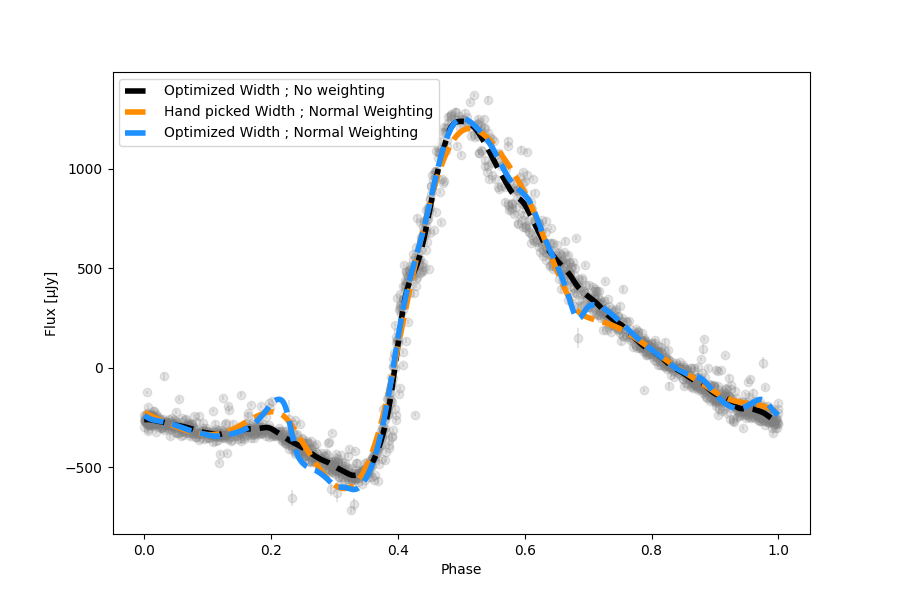

In [31]:

fig, ax = plt.subplots(1,1,num=plt_num, figsize=(9,6))
plt_num += 1

ax.errorbar(ph_, flux_centered, yerr=flux_error, color='grey', fmt='o',alpha=0.2)
ax.plot(ph_sorted, regressor_sorted, color='black',ls='--', lw=4, zorder=999, label='Optimized Width ; No weighting')
ax.plot(ph_sorted, regressor_weighted_sorted, color='darkorange',ls='--', lw=4, zorder=999, label='Hand picked Width ; Normal Weighting')
ax.plot(ph_sorted, regressor_weighted_opt_width_sorted, color='dodgerblue',ls='--', lw=4, zorder=999, label='Optimized Width ; Normal Weighting')
ax.legend(loc='upper left')
ax.set_xlabel('Phase')
ax.set_ylabel('Flux [μJy]')